In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
import pandas

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'train': 244, 'val': 153}

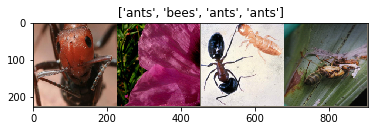

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/devendramishra/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5410 Acc: 0.7828
val Loss: 0.2223 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4146 Acc: 0.8484
val Loss: 0.8855 Acc: 0.7059

Epoch 2/24
----------
train Loss: 0.4639 Acc: 0.8320
val Loss: 0.2683 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4848 Acc: 0.8361
val Loss: 0.3634 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4257 Acc: 0.8115
val Loss: 0.3053 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3373 Acc: 0.8689
val Loss: 0.3211 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3320 Acc: 0.8443
val Loss: 0.3007 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3506 Acc: 0.8648
val Loss: 0.2823 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3596 Acc: 0.8484
val Loss: 0.2905 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3230 Acc: 0.8484
val Loss: 0.2795 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3759 Acc: 0.8443
val Loss: 0.2866 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3011 Acc: 0.8402
val Loss: 0.2822 Acc: 0.9020

Ep

In [24]:
help(model_ft.fc)

Help on Linear in module torch.nn.modules.linear object:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features, out_features, bias=True)
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
 |        additional dimensions and :math:`H_{in} = \text{in\_features}`
 |      - Output: :math:`(N, *, H_{out})` where all but the last dimension
 |        are the same shape as the input and :math:`H_{out} = \text{out\_features}`.
 |  
 |  Attributes:
 |      weight: the learnable weights of the module of shape
 |          :math:`(\text{out\_features}, \text{in\_features})`. The values are
 |          initialized from :math:`\mathcal{U}(-\sqrt{k}

In [23]:
help(num_ftrs)

Help on int object:

class int(object)
 |  int([x]) -> integer
 |  int(x, base=10) -> integer
 |  
 |  Convert a number or string to an integer, or return 0 if no arguments
 |  are given.  If x is a number, return x.__int__().  For floating point
 |  numbers, this truncates towards zero.
 |  
 |  If x is not a number or if base is given, then x must be a string,
 |  bytes, or bytearray instance representing an integer literal in the
 |  given base.  The literal can be preceded by '+' or '-' and be surrounded
 |  by whitespace.  The base defaults to 10.  Valid bases are 0 and 2-36.
 |  Base 0 means to interpret the base from the string as an integer literal.
 |  >>> int('0b100', base=0)
 |  4
 |  
 |  Methods defined here:
 |  
 |  __abs__(self, /)
 |      abs(self)
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __ceil__(...)
 |      Ceiling of an Integral retur

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1294980e0>
Traceback (most recent call last):
  File "/Users/devendramishra/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/Users/devendramishra/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/Users/devendramishra/opt/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/Users/devendramishra/opt/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/Users/devendramishra/opt/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


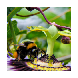

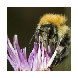

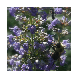

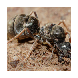

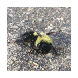

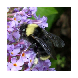

In [28]:
plt.ion()   # interactive mode
visualize_model(model_ft)